In [1]:
import csv
import os

import numpy as np
import pandas as pd
#from owid_downloader import GenerateTrainingData
#from utils import date_today, gravity_law_commute_dist

os.environ['NUMEXPR_MAX_THREADS'] = '16'
os.environ['NUMEXPR_NUM_THREADS'] = '8'

import pickle
import matplotlib.pyplot as plt
import dgl
import torch
from torch import nn
import torch.nn.functional as F
from model import STAN

import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

Using backend: pytorch


In [2]:
start_date = '2021-01-01'
end_date = '2021-05-31'

In [3]:
# data processing
raw_data = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv', usecols=["location", "date", "total_cases", "new_cases_smoothed", "total_deaths",
                    "new_deaths", "total_vaccinations", "people_fully_vaccinated", "new_vaccinations", "population"])
raw_data['date'] = pd.to_datetime(raw_data['date'])
mask = (raw_data['date'] >= start_date) & (raw_data['date'] <= end_date) # & (raw_data['location'].isin(countries))
raw_data = raw_data.loc[mask]
#print(raw_data[raw_data['location'] == 'United States']['total_cases'].values[0])
countries = []
loc_list = list(raw_data['location'].unique())
# only include countries that have more than 1000 total cases on start date and at least 1 death
for loc in loc_list:
    if raw_data[raw_data['location'] == loc]["total_cases"].values[0] > 1000 and \
        raw_data[raw_data['location'] == loc]["total_deaths"].values[0] > 0:
        countries.append(loc)
# hard-coded; these are problematic locations (non-countries) that need to be removed
to_remove = ["European Union", "Europe", "Africa", "Asia", "North America", "Oceania", "South America", "World",
            "Tajikistan", "High income", "Low income", "Lower middle income", "Upper middle income", "Aruba", 
            "Curacao", "French Polynesia", "Gibraltar"]
for r in to_remove:
    countries.remove(r)
mask = raw_data['location'].isin(countries)
raw_data = raw_data.loc[mask]

In [4]:
n_loc = len(raw_data['location'].unique())
print(n_loc)

163


In [5]:
# Generate Graph
# add flight neighbors
# for now, add a connection if there is any flight between the two countries between start and end date
loc_list = list(raw_data['location'].unique())
flight_counts = pd.read_csv('processed_flights/flight_counts_2021_all_to_05.csv')
adj_map = {}
for each_loc in loc_list:
    df = flight_counts.loc[flight_counts["origin_country"] == each_loc]
    adj_map[each_loc] = set(df["destination_country"].unique())
flight_counts['day'] = pd.to_datetime(flight_counts['day'])

print(loc_list)

['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Cameroon', 'Canada', 'Cape Verde', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Congo', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Democratic Republic of Congo', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hong Kong', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya', 'Kosovo', 'Kuwait', 'Kyrgyzstan', 'Latvia', 'L

In [6]:
# add land neighbors
import csv
neighbor_reader = csv.reader(open('neighbors.csv', 'r'))
neighbors = {}
for row in neighbor_reader:
   neighbors[row[0]] = row[1].split(',')
for each_loc,connected in adj_map.items():
    for neighbor in neighbors[each_loc]:
        if neighbor in loc_list:
            connected.add(neighbor)

In [7]:
# create graph
rows = []
cols = []
for each_loc in adj_map:
    for each_loc2 in adj_map[each_loc]:
        if each_loc in loc_list and each_loc2 in loc_list:
            rows.append(loc_list.index(each_loc))
            cols.append(loc_list.index(each_loc2))
#print(rows)
#print(cols)
g = dgl.graph((rows, cols))
print(g.number_of_nodes)

<bound method DGLHeteroGraph.number_of_nodes of Graph(num_nodes=163, num_edges=3765,
      ndata_schemes={}
      edata_schemes={})>


In [8]:
print(flight_counts.head())

e_matrix = np.zeros((n_loc, n_loc)) # edge weight matrix for every time period 
df = flight_counts.groupby(["origin_country"])
for loc in range(n_loc):
    try:
        src_df = df.get_group(loc_list[loc])
        src_df = src_df.groupby(["destination_country"])
        for loc2 in range(n_loc):
            try:
                dst_df = src_df.get_group(loc_list[loc2])
                e_matrix[loc, loc2] = dst_df['flight_count'].sum()
            except:
                continue
    except:
        continue

         day origin_country destination_country  flight_count
0 2021-01-01      Australia              Brunei             1
1 2021-01-01      Australia               China             1
2 2021-01-01      Australia           Hong Kong             4
3 2021-01-01      Australia               India             1
4 2021-01-01      Australia               Japan             1


In [9]:
threshold = 50 # for now, include edges if there are >= 50 flights between the countries
to_include = set()
edge_list = []
for orig,dest in zip(rows,cols):
    if e_matrix[orig][dest] >= threshold:
        edge_list.append((orig, dest))
        to_include.add(orig)
        to_include.add(dest)
print(len(edge_list))
print(len(to_include))

1454
88


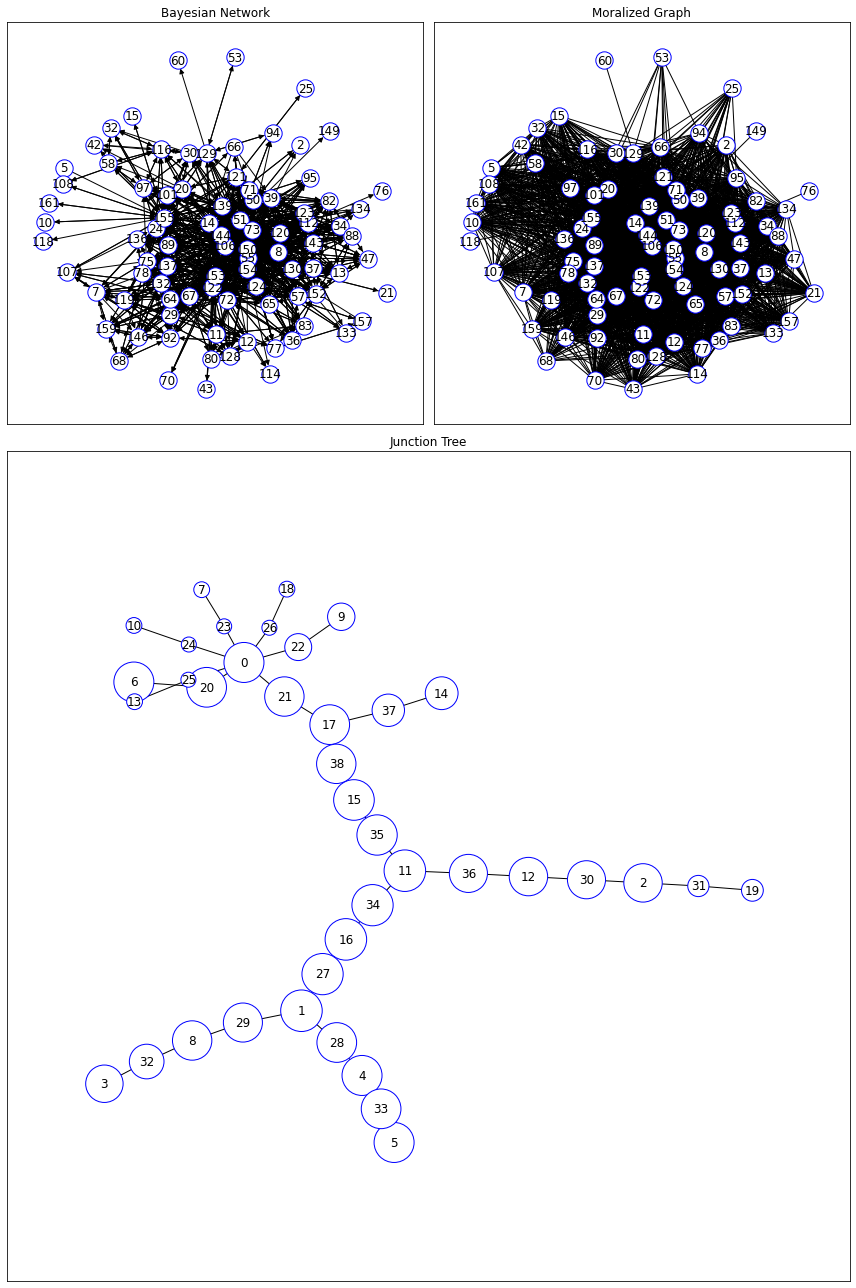

In [10]:
import matplotlib.pyplot as plt
import networkx as nx

B = nx.DiGraph()
B.add_nodes_from(to_include)
B.add_edges_from(edge_list)

options = {"with_labels": True, "node_color": "white", "edgecolors": "blue"}

fig = plt.figure(figsize=(12, 18))
axgrid = fig.add_gridspec(3, 2)

ax1 = fig.add_subplot(axgrid[0, 0])
ax1.set_title("Bayesian Network")
pos = nx.nx_agraph.graphviz_layout(B, prog="neato")
nx.draw_networkx(B, pos=pos, **options)

mg = nx.moral_graph(B)
ax2 = fig.add_subplot(axgrid[0, 1], sharex=ax1, sharey=ax1)
ax2.set_title("Moralized Graph")
nx.draw_networkx(mg, pos=pos, **options)

jt = nx.junction_tree(B)
ax3 = fig.add_subplot(axgrid[1:, :])
ax3.set_title("Junction Tree")
ax3.margins(0.15, 0.25)
nsize = [25 * len(n) + 200 for n in list(jt.nodes())]

labels_to_int = {}
int_to_labels = {}
for i, label in enumerate(jt):
    labels_to_int[label] = i
    int_to_labels[i] = label

# update labels to ints
nx.relabel_nodes(jt, labels_to_int, copy=False)
pos = nx.nx_agraph.graphviz_layout(jt, prog="neato")
# changes back to original labels
nx.relabel_nodes(jt, int_to_labels, copy=False)
label_pos = {label: pos[labels_to_int[label]] for label in jt}

labeldict = {}
for i,node in enumerate(jt.nodes()):
    labeldict[node] = i

# pos = nx.spring_layout(jt)
nx.draw_networkx(jt, pos=label_pos, node_size=nsize, labels=labeldict, **options)

plt.tight_layout()
plt.show()

In [11]:
# for k,v in labeldict.items():
#     print(f"node {k} corresponds to group {v}")
#     print(len(k))
label_to_node = {} # map label of node to country indices in its group
for k,v in labeldict.items():
    label_to_node[v] = k

In [13]:
# while leaves is not empty
# get the nodes that only have one edge in the tree
# build model around the node's countries/models and make this node new leaf
# work up until at root (say 0 for now)

# example
import stan_sirvc_layer as ssl
leaf = 3
to_include = [countries[i] for i in label_to_node[leaf]]
print(to_include)
node_mask = raw_data['location'].isin(countries)
countries_data = raw_data.loc[node_mask]

test_window = 29
history_window=14 # days of information
pred_window=14 # predicts future # of days
test_start_date = pd.to_datetime(end_date) + pd.DateOffset(days=-test_window)
g, sum_features, sum_active_cases, sum_static_feat, sum_norms = ssl.get_features(countries_data, start_date, end_date, to_include, edges=False, sum=True)
# get true_dI for each continent
true_dI_train = sum_features[0][5] # 0=train, 5=yI; locations, timesteps, values
true_dI_val = sum_features[1][5]

# target for train and test
true_dI_prev = np.concatenate((true_dI_train, true_dI_val), axis=1)
true_dI_test = sum_features[2][5]

['Argentina', 'Australia', 'Austria', 'Bahamas', 'Belgium', 'Belize', 'Brazil', 'Canada', 'China', 'Colombia', 'Costa Rica', 'Denmark', 'Ecuador', 'Finland', 'France', 'Germany', 'Guatemala', 'Hong Kong', 'Iceland', 'India', 'Ireland', 'Israel', 'Italy', 'Japan', 'Kenya', 'Luxembourg', 'Mexico', 'Morocco', 'Netherlands', 'New Zealand', 'Nicaragua', 'Panama', 'Philippines', 'Poland', 'Portugal', 'Qatar', 'Russia', 'Senegal', 'Serbia', 'Singapore', 'South Korea', 'Spain', 'Switzerland', 'Turkey', 'United Arab Emirates', 'United Kingdom', 'United States', 'Zambia']
<bound method DGLHeteroGraph.number_of_nodes of Graph(num_nodes=163, num_edges=3765,
      ndata_schemes={}
      edata_schemes={})>
done
done
(163, 18, 42)
(1, 18)
(1, 18)
(163, 18)
(163, 18)
(163, 18, 14)
(163, 18, 14)
(1, 18, 14)


AttributeError: 'list' object has no attribute 'shape'

In [13]:
pred_I, pred_I_prev = ssl.run_layer(g, sum_features, sum_active_cases, sum_static_feat, sum_norms, start_date, end_date, ["all"], "all") 

IndexError: index 0 is out of bounds for dimension 0 with size 0